# Artificial Intelligence (GK5937)

Vietnam Gold Price Prediction

---




## Import các thư viện
---

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, LSTM, Dropout

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


## 1. Đọc dữ liệu
---

In [3]:

file_name = "gold_prices.csv"
df = pd.read_csv(file_name)
print('Size of Dataset is', df.shape)

df =df.tail(832)
# Show vài dòng đầu tiên của dữ liệu
df.head()

Size of Dataset is (1625, 3)


,date,buy_price,sell_price
793,04-03-2022,"66,950","67,700"
794,05-03-2022,"68,000","69,300"
795,06-03-2022,"68,000","69,000"
796,07-03-2022,"71,700","73,500"
797,08-03-2022,"70,200","72,000"


In [4]:
#Show vài dòng cuối của dữ liệu
df.tail(5)

,date,buy_price,sell_price
1620,08-06-2024,"74,980","76,980"
1621,09-06-2024,"74,980","76,980"
1622,10-06-2024,"74,980","76,980"
1623,11-06-2024,"74,980","76,980"
1624,12-06-2024,"74,980","76,980"


## 2. Khám phá dữ liệu
---


Các thông tin thống kê cơ bản: max, min, mean của các columns trong dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 793 to 1624
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        832 non-null    object
 1   buy_price   831 non-null    object
 2   sell_price  831 non-null    object
dtypes: object(3)
memory usage: 19.6+ KB


In [6]:
features = df.columns
features

Index(['date', 'buy_price', 'sell_price'], dtype='object')

In [7]:
df.describe()

,date,buy_price,sell_price
count,832,831,831
unique,832,200,195
top,04-03-2022,"66,650","67,250"
freq,1,41,46


## 3. Visualization

Trực quan hóa dữ liệu bằng các đồ thị dưới đây

## 4. Check and preprocess data

---



### 4.1. Loại bỏ dữ liệu `NULL` hay `NAN`

---



In [8]:
df_cleaned = df.copy()
df_cleaned = df_cleaned.dropna(axis=0, how='any')
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 831 entries, 793 to 1624
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        831 non-null    object
 1   buy_price   831 non-null    object
 2   sell_price  831 non-null    object
dtypes: object(3)
memory usage: 26.0+ KB


### 4.2. Xử lý kiểu dữ liệu

---



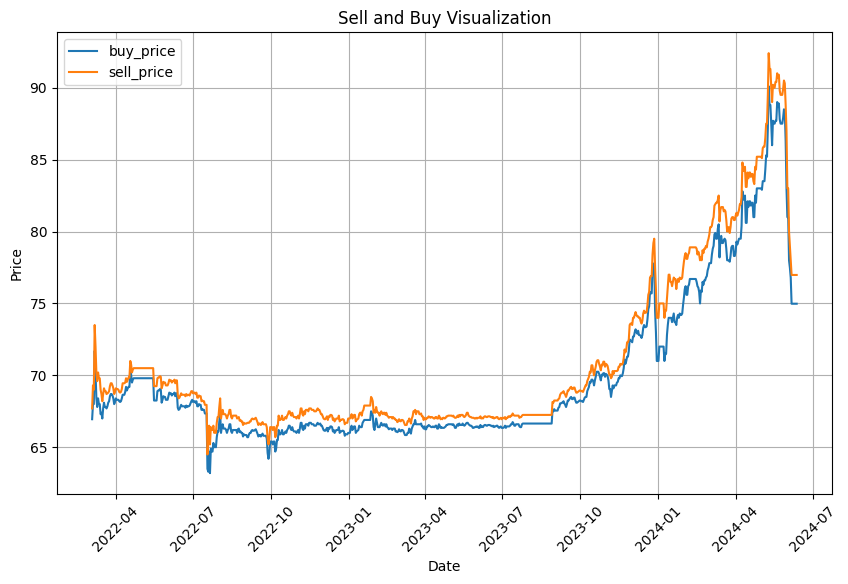

In [9]:

feature0 = features[0]
feature1 = features[1]
feature2 = features[2]
date_format = '%d-%m-%Y'

# Convert the 'buy' and 'sell' columns to numeric
data = df_cleaned.copy()
data[feature0] = pd.to_datetime(df_cleaned[feature0], format=date_format)
data[feature1] = df_cleaned[feature1].str.replace(',', '.').astype(float)
data[feature2] = df_cleaned[feature2].str.replace(',', '.').astype(float)

# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(data[feature0], data[feature1], label = feature1)
plt.plot(data[feature0], data[feature2], label = feature2)

# Thêm các nhãn và tiêu đề
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Sell and Buy Visualization')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

### 4.3. Phân chia data

---



In [10]:

window_size = 30
split_ratio = 0.80

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_sorted = data.copy()
data_sorted = data_sorted.sort_values(by=feature0)
data_scaled = scaler.fit_transform(data_sorted[[feature1, feature2]])

# Split data into training and testing sets
train_size = int(len(data_scaled) * split_ratio)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Prepare input and output data for LSTM model
X_train, X_test = [], []
y_train, y_test = [], []

# Create sliding window for prediction
for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i])
    y_train.append(train_data[i, :2])             # Only predict 'buy' and 'sell' columns


for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i])
    y_test.append(test_data[i, :2])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

## 5. LSTM
---

## 5.1 Model 1

In [11]:
# Define LSTM model
model_1 = Sequential()
model_1.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_1.add(Dropout(0.2))
model_1.add(LSTM(units=32, return_sequences=False))
model_1.add(Dropout(0.2))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dense(units=X_train.shape[2]))
# In ra tóm tắt mô hình
print(model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            17152     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 30130 (117.70 KB)
Trainable params: 30130 

In [12]:
# Compile and train model
model_1.compile(optimizer='adam', loss='mean_squared_error')
model_1.fit(X_train, y_train, epochs=100, batch_size = 32, validation_data=(X_test, y_test))

Epoch 1/100
20/20 [==============================] - 7s 77ms/step - loss: 0.0085 - val_loss: 0.1093
Epoch 2/100
20/20 [==============================] - 1s 36ms/step - loss: 0.0023 - val_loss: 0.0266
Epoch 3/100
20/20 [==============================] - 1s 30ms/step - loss: 0.0015 - val_loss: 0.0153
Epoch 4/100
20/20 [==============================] - 1s 31ms/step - loss: 0.0010 - val_loss: 0.0240
Epoch 5/100
20/20 [==============================] - 1s 32ms/step - loss: 8.4796e-04 - val_loss: 0.0210
Epoch 6/100
20/20 [==============================] - 1s 31ms/step - loss: 7.2052e-04 - val_loss: 0.0261
Epoch 7/100
20/20 [==============================] - 1s 31ms/step - loss: 7.6165e-04 - val_loss: 0.0405
Epoch 8/100
20/20 [==============================] - 1s 28ms/step - loss: 8.1053e-04 - val_loss: 0.0378
Epoch 9/100
20/20 [==============================] - 1s 30ms/step - loss: 7.9799e-04 - val_loss: 0.0506
Epoch 10/100
20/20 [==============================] - 1s 36ms/step - loss: 7.010

## 5.2 Model 2

In [13]:
# Define LSTM model
model_2 = Sequential()
model_2.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=64, return_sequences=False))
model_2.add(Dropout(0.2))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(units=X_train.shape[2]))
# In ra tóm tắt mô hình
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 128)           67072     
                                                                 
 dropout_2 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 118626 (463.38 KB)
Trainable params: 118

In [14]:
# Compile and train model
model_2.compile(optimizer='adam', loss='mean_squared_error')
model_2.fit(X_train, y_train, epochs=100, batch_size = 32, validation_data=(X_test, y_test))

Epoch 1/100
20/20 [==============================] - 8s 115ms/step - loss: 0.0058 - val_loss: 0.0195
Epoch 2/100
20/20 [==============================] - 1s 56ms/step - loss: 0.0013 - val_loss: 0.0137
Epoch 3/100
20/20 [==============================] - 1s 67ms/step - loss: 7.4498e-04 - val_loss: 0.0331
Epoch 4/100
20/20 [==============================] - 2s 111ms/step - loss: 6.0169e-04 - val_loss: 0.0419
Epoch 5/100
20/20 [==============================] - 2s 92ms/step - loss: 6.9036e-04 - val_loss: 0.0233
Epoch 6/100
20/20 [==============================] - 3s 145ms/step - loss: 6.3730e-04 - val_loss: 0.0365
Epoch 7/100
20/20 [==============================] - 2s 96ms/step - loss: 6.7391e-04 - val_loss: 0.0354
Epoch 8/100
20/20 [==============================] - 2s 88ms/step - loss: 4.5383e-04 - val_loss: 0.0679
Epoch 9/100
20/20 [==============================] - 3s 129ms/step - loss: 4.6773e-04 - val_loss: 0.0726
Epoch 10/100
20/20 [==============================] - 2s 78ms/step -

## 5.3 Model 3

In [20]:
# Define LSTM model
model_3 = Sequential()
model_3.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_3.add(Dropout(0.2))
model_3.add(LSTM(units=64, return_sequences=True))
model_3.add(Dropout(0.2))
model_3.add(LSTM(units=32, return_sequences=False))
model_3.add(Dropout(0.2))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dense(units=X_train.shape[2]))
# In ra tóm tắt mô hình
print(model_3.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 30, 128)           67072     
                                                                 
 dropout_14 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_20 (LSTM)              (None, 30, 64)            49408     
                                                                 
 dropout_15 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_21 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)               

In [21]:
# Compile and train model
model_3.compile(optimizer='adam', loss='mean_squared_error')
model_3.fit(X_train, y_train, epochs=100, batch_size = 32, validation_data=(X_test, y_test))

Epoch 1/100
20/20 [==============================] - 10s 139ms/step - loss: 0.0100 - val_loss: 0.1367
Epoch 2/100
20/20 [==============================] - 1s 72ms/step - loss: 0.0023 - val_loss: 0.0407
Epoch 3/100
20/20 [==============================] - 1s 70ms/step - loss: 0.0013 - val_loss: 0.0278
Epoch 4/100
20/20 [==============================] - 1s 74ms/step - loss: 0.0015 - val_loss: 0.0195
Epoch 5/100
20/20 [==============================] - 2s 94ms/step - loss: 0.0011 - val_loss: 0.0147
Epoch 6/100
20/20 [==============================] - 2s 123ms/step - loss: 0.0010 - val_loss: 0.0133
Epoch 7/100
20/20 [==============================] - 1s 72ms/step - loss: 9.0799e-04 - val_loss: 0.0130
Epoch 8/100
20/20 [==============================] - 1s 72ms/step - loss: 9.8334e-04 - val_loss: 0.0153
Epoch 9/100
20/20 [==============================] - 1s 74ms/step - loss: 0.0010 - val_loss: 0.0139
Epoch 10/100
20/20 [==============================] - 2s 79ms/step - loss: 7.8823e-04 - v

## 5.4 Model 4

In [22]:
# Define LSTM model
model_4 = Sequential()
model_4.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_4.add(Dropout(0.2))
model_4.add(LSTM(units=128, return_sequences=True))
model_4.add(Dropout(0.2))
model_4.add(LSTM(units=64, return_sequences=False))
model_4.add(Dropout(0.2))
model_4.add(Dense(132, activation='relu'))
model_4.add(Dense(units=X_train.shape[2]))
# In ra tóm tắt mô hình
print(model_4.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 30, 256)           265216    
                                                                 
 dropout_17 (Dropout)        (None, 30, 256)           0         
                                                                 
 lstm_23 (LSTM)              (None, 30, 128)           197120    
                                                                 
 dropout_18 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_24 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 132)              

In [23]:
# Compile and train model
model_4.compile(optimizer='adam', loss='mean_squared_error')
model_4.fit(X_train, y_train, epochs=100, batch_size = 32, validation_data=(X_test, y_test))

Epoch 1/100
20/20 [==============================] - 13s 245ms/step - loss: 0.0054 - val_loss: 0.0257
Epoch 2/100
20/20 [==============================] - 3s 165ms/step - loss: 0.0012 - val_loss: 0.0124
Epoch 3/100
20/20 [==============================] - 5s 260ms/step - loss: 8.8272e-04 - val_loss: 0.0227
Epoch 4/100
20/20 [==============================] - 3s 173ms/step - loss: 5.9659e-04 - val_loss: 0.0455
Epoch 5/100
20/20 [==============================] - 3s 168ms/step - loss: 6.6548e-04 - val_loss: 0.0363
Epoch 6/100
20/20 [==============================] - 4s 198ms/step - loss: 5.3495e-04 - val_loss: 0.0535
Epoch 7/100
20/20 [==============================] - 4s 222ms/step - loss: 6.1552e-04 - val_loss: 0.0495
Epoch 8/100
20/20 [==============================] - 3s 168ms/step - loss: 6.4469e-04 - val_loss: 0.0595
Epoch 9/100
20/20 [==============================] - 3s 166ms/step - loss: 6.8675e-04 - val_loss: 0.0241
Epoch 10/100
20/20 [==============================] - 5s 232ms

## 6. Results

---



## 6.1 Model 1

In [24]:
# Make predictions
y_pred_1 = model_1.predict(X_test)

# Evaluate results
mae_1 = mean_absolute_error(y_test, y_pred_1)
rmse_1 = np.sqrt(mean_squared_error(y_test, y_pred_1))
r2_1 = r2_score(y_test, y_pred_1)

print('MAE:', mae_1)
print('RMSE:', rmse_1)
print('R-squared:', r2_1)


5/5 [==============================] - 1s 10ms/step
MAE: 0.08907481763713139
RMSE: 0.1112342963999537
R-squared: 0.4703275613256304


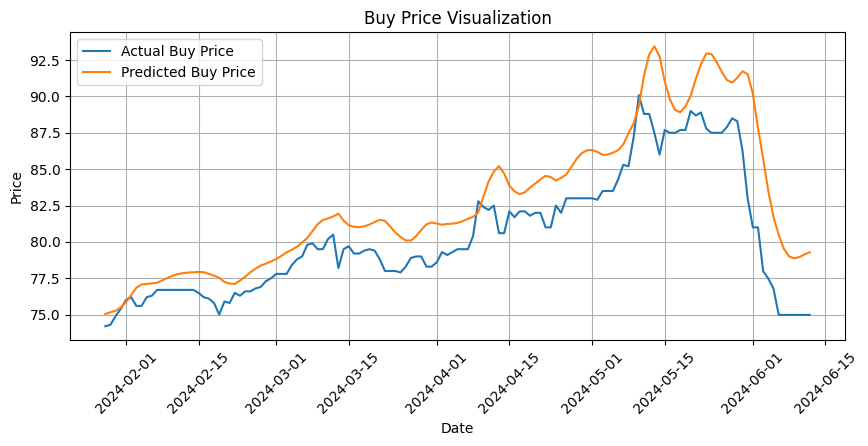

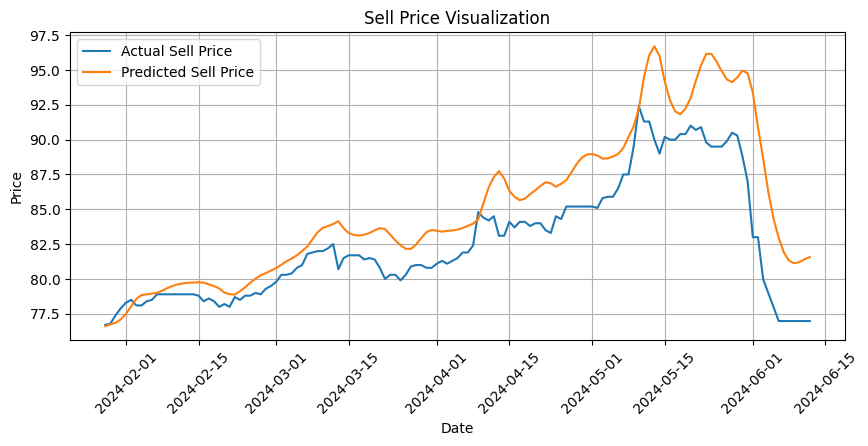

In [25]:

# Denormalize the predicted and actual values
y_test_denorm = scaler.inverse_transform(y_test)
y_pred_denorm = scaler.inverse_transform(y_pred_1)

# Extract the test data dates
test_dates = data_sorted[feature0].iloc[train_size+window_size:]

# Plot the actual and predicted values
plt.figure(figsize=(10, 4))
plt.plot(test_dates, y_test_denorm[:, 0], label='Actual Buy Price')
plt.plot(test_dates, y_pred_denorm[:, 0], label='Predicted Buy Price')

# Thêm các nhãn và tiêu đề
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Buy Price Visualization')
plt.legend()
plt.grid()
plt.xticks(rotation=45)

plt.figure(figsize=(10, 4))
plt.plot(test_dates, y_test_denorm[:, 1], label='Actual Sell Price')
plt.plot(test_dates, y_pred_denorm[:, 1], label='Predicted Sell Price')

# Thêm các nhãn và tiêu đề
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Sell Price Visualization')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()


## 6.2 Model 2

In [26]:
# Make predictions
y_pred_2 = model_2.predict(X_test)

# Evaluate results
mae_2 = mean_absolute_error(y_test, y_pred_2)
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred_2))
r2_2 = r2_score(y_test, y_pred_2)

print('MAE:', mae_2)
print('RMSE:', rmse_2)
print('R-squared:', r2_2)

5/5 [==============================] - 1s 15ms/step
MAE: 0.07281503049871112
RMSE: 0.09792128373069343
R-squared: 0.5872165764423889


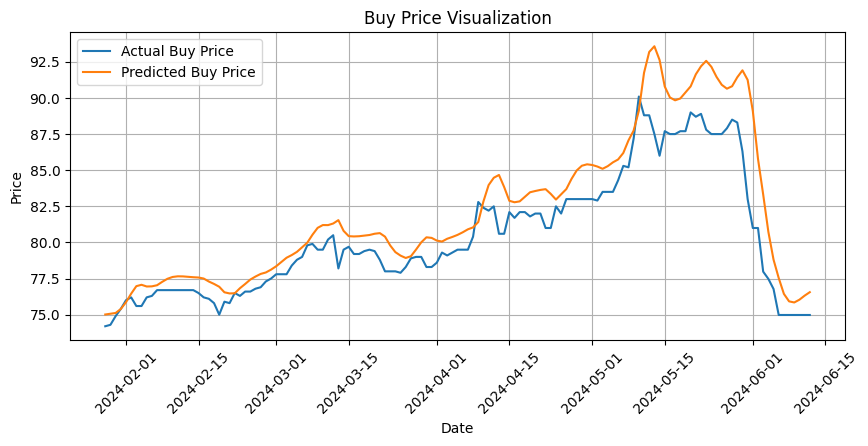

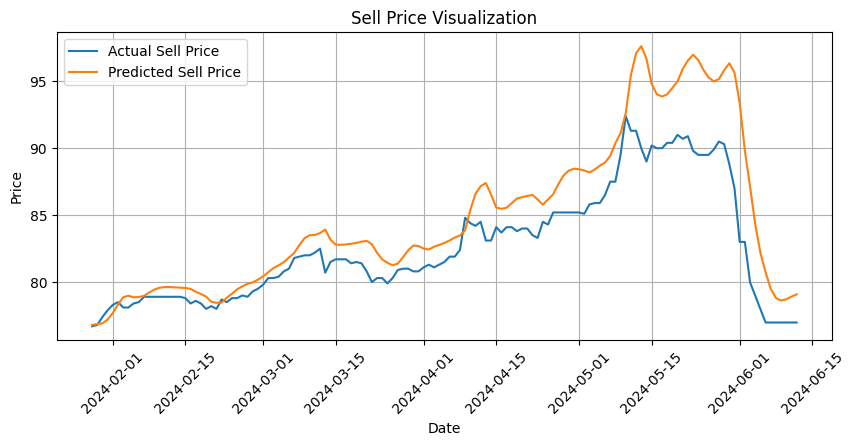

In [27]:

# Denormalize the predicted and actual values
y_test_denorm = scaler.inverse_transform(y_test)
y_pred_denorm = scaler.inverse_transform(y_pred_2)

# Extract the test data dates
test_dates = data_sorted[feature0].iloc[train_size+window_size:]

# Plot the actual and predicted values
plt.figure(figsize=(10, 4))
plt.plot(test_dates, y_test_denorm[:, 0], label='Actual Buy Price')
plt.plot(test_dates, y_pred_denorm[:, 0], label='Predicted Buy Price')

# Thêm các nhãn và tiêu đề
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Buy Price Visualization')
plt.legend()
plt.grid()
plt.xticks(rotation=45)

plt.figure(figsize=(10, 4))
plt.plot(test_dates, y_test_denorm[:, 1], label='Actual Sell Price')
plt.plot(test_dates, y_pred_denorm[:, 1], label='Predicted Sell Price')

# Thêm các nhãn và tiêu đề
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Sell Price Visualization')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

## 6.3 Model 3

In [28]:
# Make predictions
y_pred_3 = model_3.predict(X_test)

# Evaluate results
mae_3 = mean_absolute_error(y_test, y_pred_3)
rmse_3 = np.sqrt(mean_squared_error(y_test, y_pred_3))
r2_3 = r2_score(y_test, y_pred_3)

print('MAE:', mae_3)
print('RMSE:', rmse_3)
print('R-squared:', r2_3)

5/5 [==============================] - 2s 41ms/step
MAE: 0.08405285978979289
RMSE: 0.11563698804218217
R-squared: 0.43201224976196917


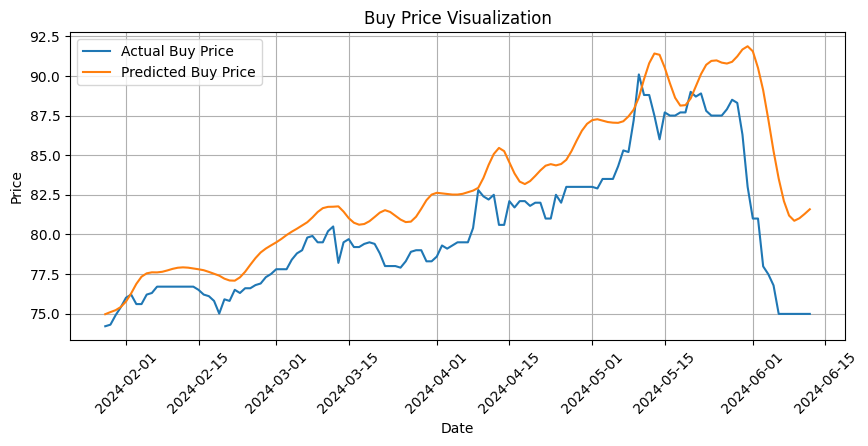

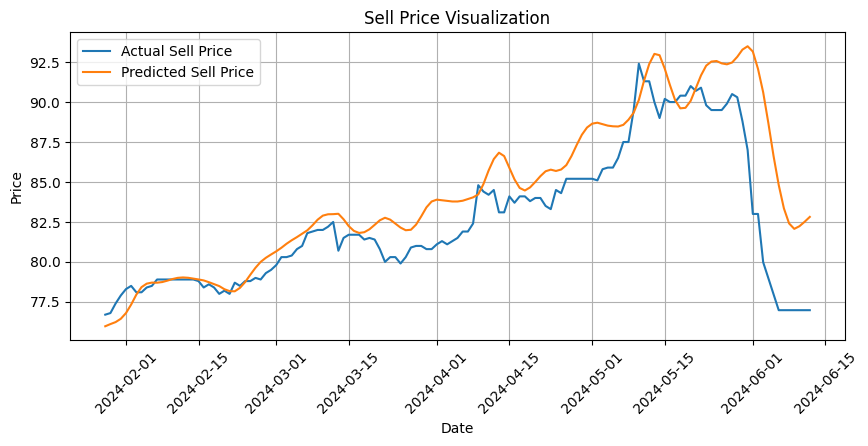

In [29]:

# Denormalize the predicted and actual values
y_test_denorm = scaler.inverse_transform(y_test)
y_pred_denorm = scaler.inverse_transform(y_pred_3)

# Extract the test data dates
test_dates = data_sorted[feature0].iloc[train_size+window_size:]

# Plot the actual and predicted values
plt.figure(figsize=(10, 4))
plt.plot(test_dates, y_test_denorm[:, 0], label='Actual Buy Price')
plt.plot(test_dates, y_pred_denorm[:, 0], label='Predicted Buy Price')

# Thêm các nhãn và tiêu đề
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Buy Price Visualization')
plt.legend()
plt.grid()
plt.xticks(rotation=45)

plt.figure(figsize=(10, 4))
plt.plot(test_dates, y_test_denorm[:, 1], label='Actual Sell Price')
plt.plot(test_dates, y_pred_denorm[:, 1], label='Predicted Sell Price')

# Thêm các nhãn và tiêu đề
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Sell Price Visualization')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

## 6.4 Model 4

In [30]:
# Make predictions
y_pred_4 = model_4.predict(X_test)

# Evaluate results
mae_4 = mean_absolute_error(y_test, y_pred_4)
rmse_4 = np.sqrt(mean_squared_error(y_test, y_pred_4))
r2_4 = r2_score(y_test, y_pred_4)

print('MAE:', mae_4)
print('RMSE:', rmse_4)
print('R-squared:', r2_4)

5/5 [==============================] - 2s 78ms/step
MAE: 0.03726371179541477
RMSE: 0.05594454610284302
R-squared: 0.8665901908951685


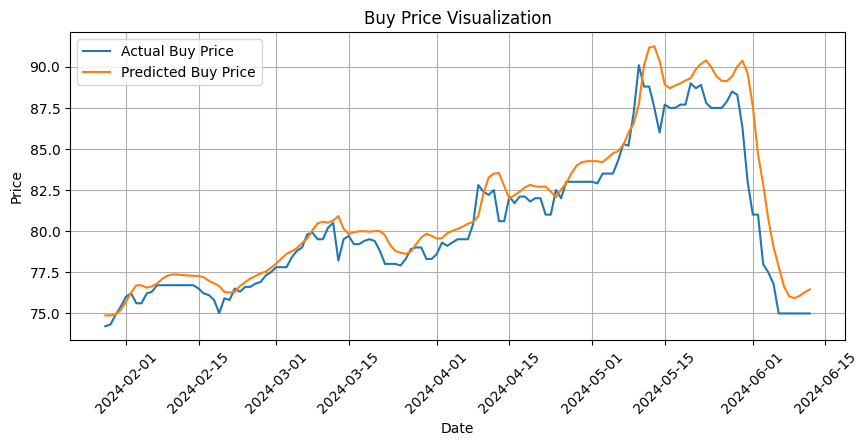

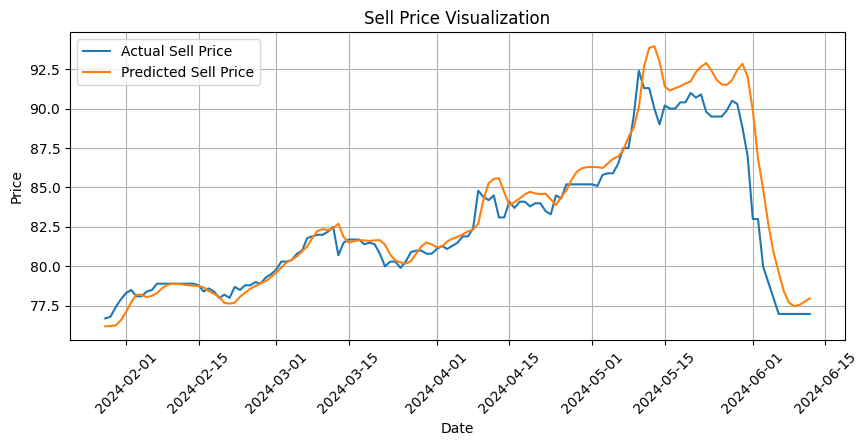

In [31]:

# Denormalize the predicted and actual values
y_test_denorm = scaler.inverse_transform(y_test)
y_pred_denorm = scaler.inverse_transform(y_pred_4)

# Extract the test data dates
test_dates = data_sorted[feature0].iloc[train_size+window_size:]

# Plot the actual and predicted values
plt.figure(figsize=(10, 4))
plt.plot(test_dates, y_test_denorm[:, 0], label='Actual Buy Price')
plt.plot(test_dates, y_pred_denorm[:, 0], label='Predicted Buy Price')

# Thêm các nhãn và tiêu đề
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Buy Price Visualization')
plt.legend()
plt.grid()
plt.xticks(rotation=45)

plt.figure(figsize=(10, 4))
plt.plot(test_dates, y_test_denorm[:, 1], label='Actual Sell Price')
plt.plot(test_dates, y_pred_denorm[:, 1], label='Predicted Sell Price')

# Thêm các nhãn và tiêu đề
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Sell Price Visualization')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()